
## Helmet Use Prediction Model

### Machine Learning Analysis for Accident Data




In [ ]:
# ### 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, roc_curve)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

print("Libraries imported successfully!")


Libraries imported successfully!


In [48]:
# Load data
df = pd.read_csv('accident_data.csv')

In [49]:
# Clean column names and string values
df.columns = df.columns.str.strip()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

# Basic information
print("Dataset Shape:", df.shape)
print("\nColumn Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Variable Distribution:")
print(df['Helmet_Use'].value_counts())
print(f"\nHelmet Use Rate: {(df['Helmet_Use'] == 'Yes').mean():.2%}")

# %%
# Statistical summary
df.describe()

Dataset Shape: (500, 14)

Column Types:
Year                      int64
Country                  object
Accident_ID              object
Accident_Severity        object
Helmet_Use               object
Injury_Severity_Score     int64
Road_Type                object
Weather_Condition        object
Time_of_Day              object
Age_of_Driver             int64
Helmet_Law_Enforced      object
Traffic_Density          object
Alcohol_Involved         object
Speed_Limit              object
dtype: object

Missing Values:
Year                     0
Country                  0
Accident_ID              0
Accident_Severity        0
Helmet_Use               0
Injury_Severity_Score    0
Road_Type                0
Weather_Condition        0
Time_of_Day              0
Age_of_Driver            0
Helmet_Law_Enforced      0
Traffic_Density          0
Alcohol_Involved         0
Speed_Limit              0
dtype: int64

Target Variable Distribution:
Helmet_Use
Yes    274
No     226
Name: count, dtype: int64


,Year,Injury_Severity_Score,Age_of_Driver
count,500.00000,500.000000,500.000000
mean,2019.53600,7.812000,38.382000
std,2.33315,4.311593,12.225998
min,2016.00000,1.000000,18.000000
25%,2018.00000,4.000000,27.000000
50%,2019.00000,7.000000,39.000000
75%,2022.00000,12.000000,49.000000
max,2023.00000,15.000000,59.000000


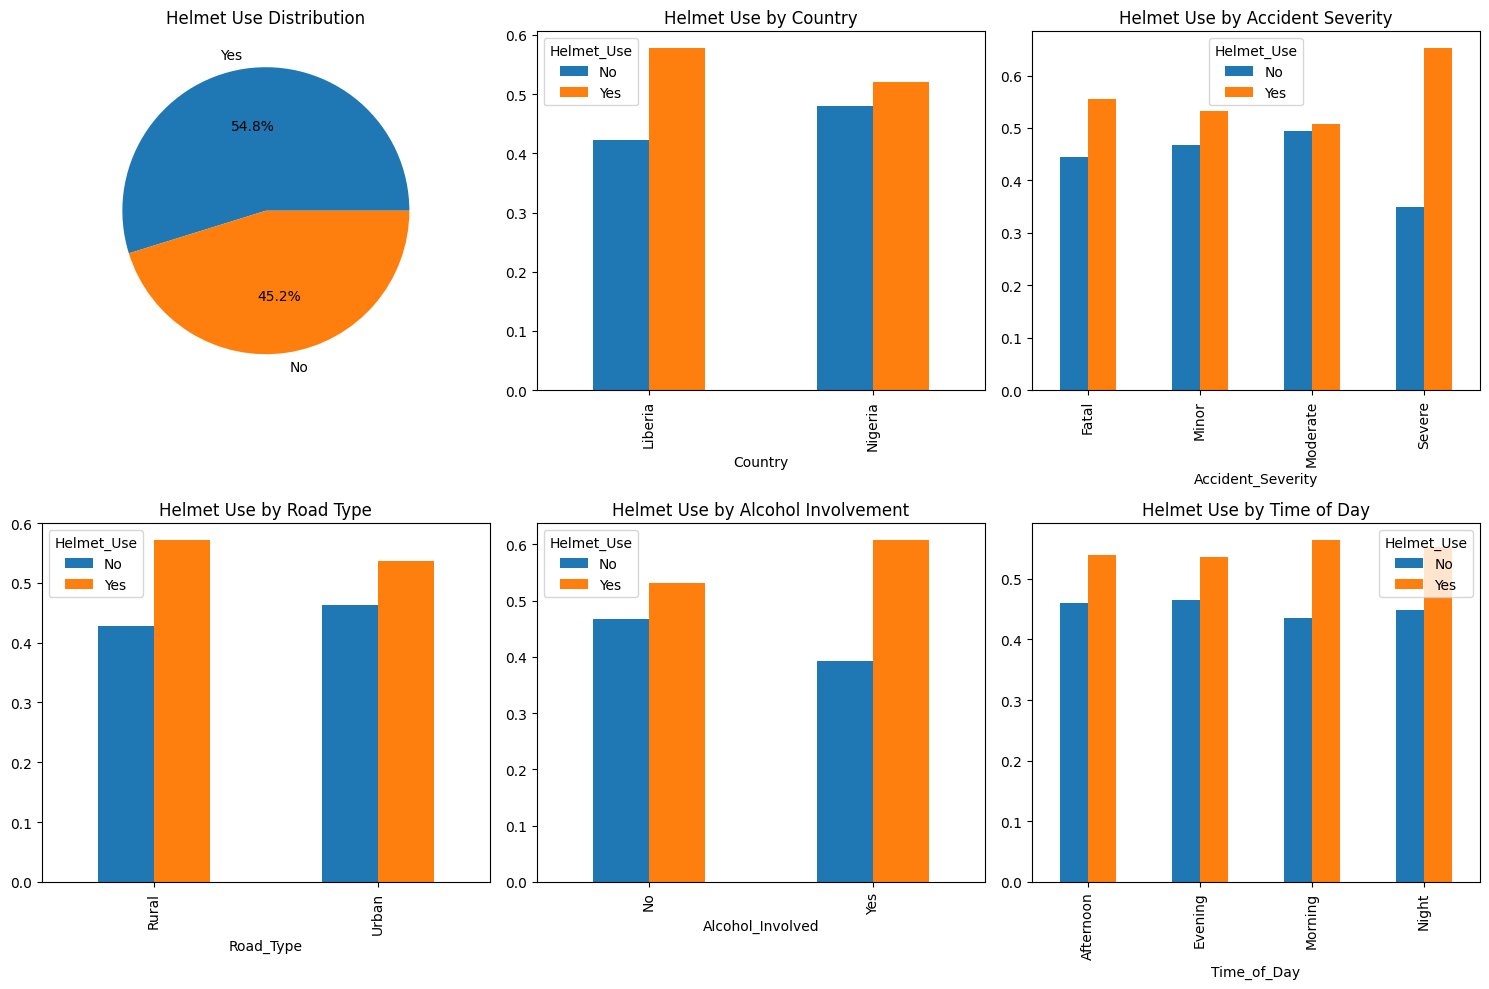

In [50]:
# %%
# Quick visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Helmet use distribution
helmet_counts = df['Helmet_Use'].value_counts()
axes[0, 0].pie(helmet_counts.values, labels=helmet_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Helmet Use Distribution')

# By country
pd.crosstab(df['Country'], df['Helmet_Use'], normalize='index').plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Helmet Use by Country')

# By accident severity
pd.crosstab(df['Accident_Severity'], df['Helmet_Use'], normalize='index').plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('Helmet Use by Accident Severity')

# By road type
pd.crosstab(df['Road_Type'], df['Helmet_Use'], normalize='index').plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Helmet Use by Road Type')

# By alcohol involvement
pd.crosstab(df['Alcohol_Involved'], df['Helmet_Use'], normalize='index').plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Helmet Use by Alcohol Involvement')

# By time of day
pd.crosstab(df['Time_of_Day'], df['Helmet_Use'], normalize='index').plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Helmet Use by Time of Day')

plt.tight_layout()
plt.show()

# %% [markdown]
# ### 3. Feature Engineering


In [51]:
# Create new features
df_model = df.copy()

# Risk Score
df_model['High_Speed'] = df_model['Speed_Limit'].isin(['61-80 km/h', '80+ km/h']).astype(int)
df_model['Night_Driving'] = (df_model['Time_of_Day'] == 'Night').astype(int)
df_model['Bad_Weather'] = (df_model['Weather_Condition'] != 'Clear').astype(int)
df_model['Rural_Road'] = (df_model['Road_Type'] == 'Rural').astype(int)
df_model['High_Traffic'] = (df_model['Traffic_Density'] == 'High').astype(int)

df_model['Risk_Score'] = (df_model['High_Speed'] + df_model['Night_Driving'] + 
                          df_model['Bad_Weather'] + df_model['Rural_Road'] + 
                          df_model['High_Traffic'] + 
                          (df_model['Alcohol_Involved'] == 'Yes').astype(int))

# Age indicators
df_model['Young_Driver'] = (df_model['Age_of_Driver'] < 25).astype(int)
df_model['Senior_Driver'] = (df_model['Age_of_Driver'] > 55).astype(int)

print("Features created successfully!")
print(f"Total features: {len(df_model.columns)}")

Features created successfully!
Total features: 22


 4. Prepare Data for Modeling

In [52]:
# Prepare features and target
X = df_model.drop(['Helmet_Use', 'Accident_ID'], axis=1)
y = (df_model['Helmet_Use'] == 'Yes').astype(int)

# Encode categorical variables
label_encoders = {}
categorical_columns = X.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print(f"Encoded {len(categorical_columns)} categorical columns")

# %%
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['Age_of_Driver', 'Injury_Severity_Score', 'Risk_Score']

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training: {y_train.value_counts(normalize=True).round(3).to_dict()}")

# %% [markdown]
# ### 5. Train Models

# %%
# Train three models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

results = {}

Encoded 9 categorical columns
Training set: (400, 20)
Test set: (100, 20)

Class distribution in training: {1: 0.548, 0: 0.452}



Logistic Regression:
  Accuracy:  0.6100
  Precision: 0.6053
  Recall:    0.8364
  F1-Score:  0.7023
  ROC-AUC:   0.6097

Decision Tree:
  Accuracy:  0.4400
  Precision: 0.4906
  Recall:    0.4727
  F1-Score:  0.4815
  ROC-AUC:   0.4364

Random Forest:
  Accuracy:  0.4300
  Precision: 0.4833
  Recall:    0.5273
  F1-Score:  0.5043
  ROC-AUC:   0.4265


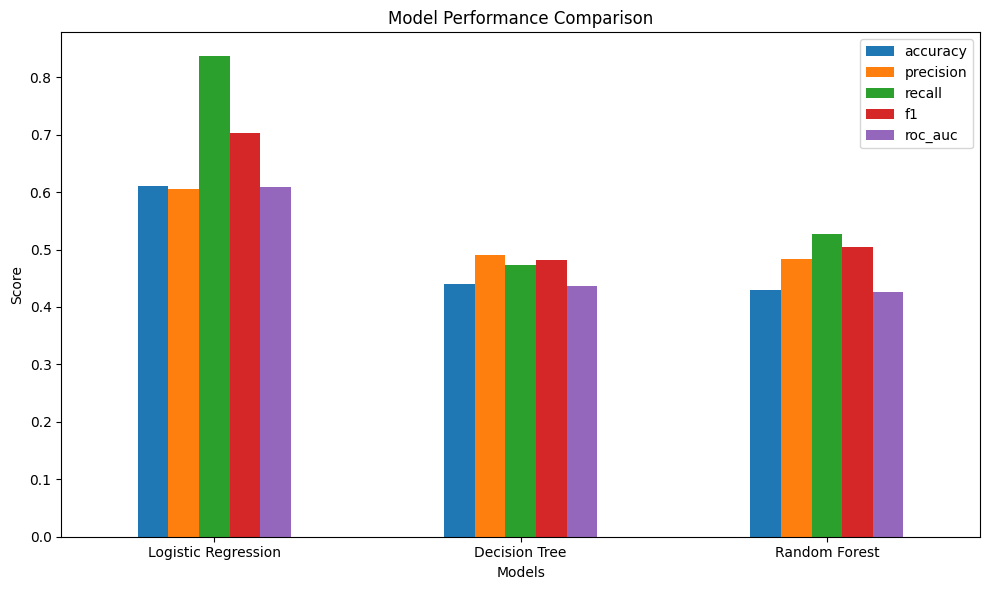

Best performing model (by Precision): Logistic Regression
Precision: 0.6053

Other metrics for Logistic Regression:
  Recall: 0.8364
  F1-Score: 0.7023
  Accuracy: 0.6100

Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Precision: 0.5386

Test set metrics after tuning:
  Precision: 0.5556
  Recall: 1.0000
  F1-Score: 0.7143


In [53]:
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {results[name]['accuracy']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall:    {results[name]['recall']:.4f}")
    print(f"  F1-Score:  {results[name]['f1']:.4f}")
    print(f"  ROC-AUC:   {results[name]['roc_auc']:.4f}")

# %%
# Visualize model comparison
metrics_df = pd.DataFrame({name: {k: v for k, v in res.items() 
                                  if k in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']} 
                          for name, res in results.items()}).T

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# %%
# Find the best performing model based on PRECISION
best_model_name = max(results, key=lambda x: results[x]['precision'])
print(f"Best performing model (by Precision): {best_model_name}")
print(f"Precision: {results[best_model_name]['precision']:.4f}")

# Also show other metrics for context
print(f"\nOther metrics for {best_model_name}:")
print(f"  Recall: {results[best_model_name]['recall']:.4f}")
print(f"  F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"  Accuracy: {results[best_model_name]['accuracy']:.4f}")

# %% [markdown]
# ### 6. Hyperparameter Tuning

# %%
# Define parameter grids for all models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# Tune the best performing model
print(f"\nTuning {best_model_name}...")
best_base_model = results[best_model_name]['model']

# Get the appropriate parameter grid
param_grid = param_grids[best_model_name]

# Create new instance of the model type
if best_model_name == 'Logistic Regression':
    model_to_tune = LogisticRegression(random_state=42, max_iter=1000)
elif best_model_name == 'Decision Tree':
    model_to_tune = DecisionTreeClassifier(random_state=42)
else:
    model_to_tune = RandomForestClassifier(random_state=42)

# Perform grid search - OPTIMIZE FOR PRECISION
grid_search = GridSearchCV(model_to_tune, param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters for {best_model_name}:", grid_search.best_params_)
print(f"Best CV Precision: {grid_search.best_score_:.4f}")

# Get the best tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
print(f"\nTest set metrics after tuning:")
print(f"  Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_tuned):.4f}")

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   No Helmet       1.00      0.02      0.04        45
      Helmet       0.56      1.00      0.71        55

    accuracy                           0.56       100
   macro avg       0.78      0.51      0.38       100
weighted avg       0.76      0.56      0.41       100



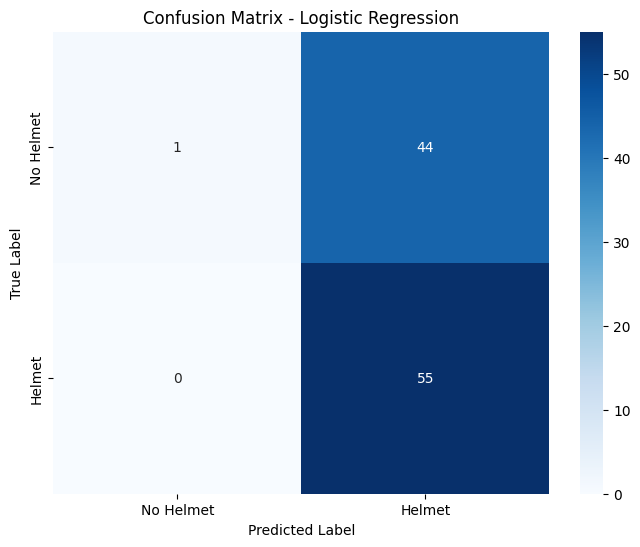

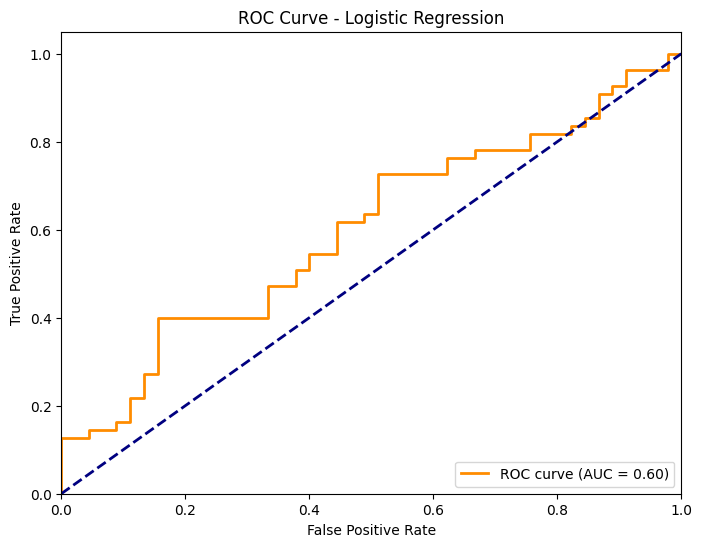

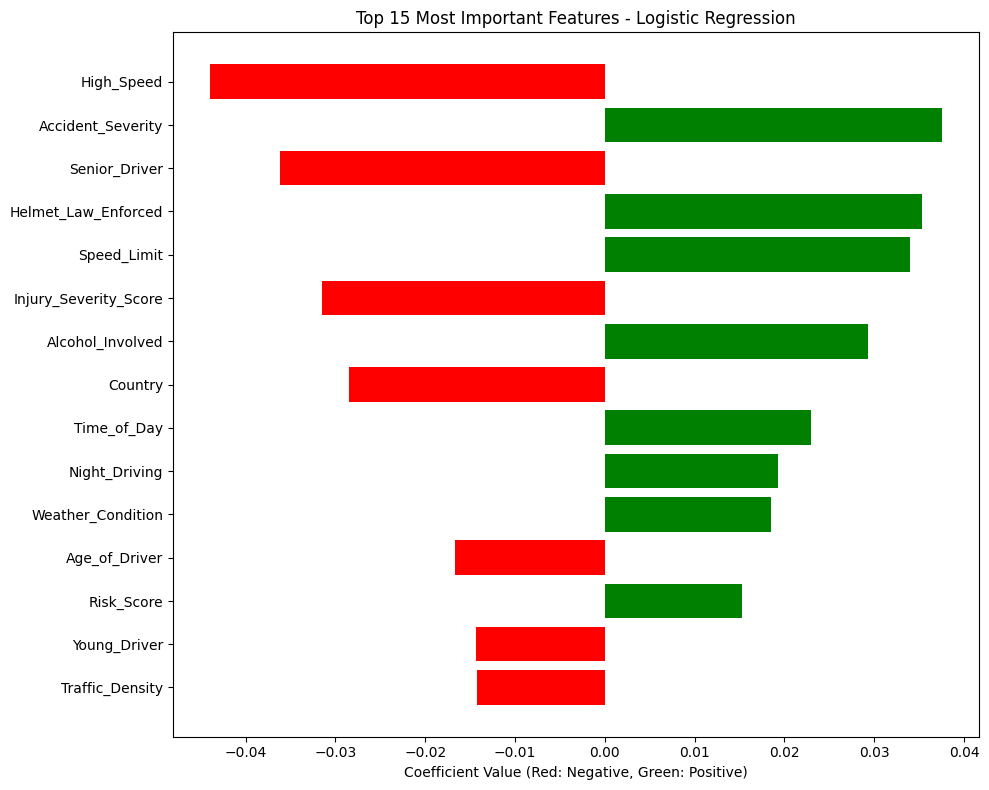

Top 10 Most Important Features (by absolute coefficient):
Positive coefficient = increases helmet use probability
Negative coefficient = decreases helmet use probability
              feature  coefficient
           High_Speed    -0.043976
    Accident_Severity     0.037540
        Senior_Driver    -0.036136
  Helmet_Law_Enforced     0.035348
          Speed_Limit     0.033919
Injury_Severity_Score    -0.031505
     Alcohol_Involved     0.029304
              Country    -0.028452
          Time_of_Day     0.022984
        Night_Driving     0.019298
5-Fold Cross-Validation Results:

Precision Scores (PRIMARY METRIC):
  Mean: 0.5386
  Std:  0.0066
  Min:  0.5316
  Max:  0.5500

Recall Scores:
  Mean: 0.9544
  Std:  0.0321

F1 Scores:
  Mean: 0.6885
  Std:  0.0116
MODEL SUMMARY

Best Model: Logistic Regression

Final Performance Metrics:
  PRECISION (Primary): 55.56%
  Recall:              100.00%
  F1-Score:            0.7143
  Accuracy:            56.00%
  ROC-AUC:             0.5996

I

In [54]:


# Classification report
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred, target_names=['No Helmet', 'Helmet']))

# %%
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Helmet', 'Helmet'],
            yticklabels=['No Helmet', 'Helmet'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# %%
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

# %% [markdown]
# ### 8. Feature Importance

# %%
# Feature importance analysis (different for each model type)
if hasattr(best_model, 'feature_importances_'):  # Tree-based models
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Most Important Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
elif hasattr(best_model, 'coef_'):  # Logistic Regression
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': best_model.coef_[0]
    })
    feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
    feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value (Red: Negative, Green: Positive)')
    plt.title(f'Top 15 Most Important Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features (by absolute coefficient):")
    print("Positive coefficient = increases helmet use probability")
    print("Negative coefficient = decreases helmet use probability")
    print(feature_importance[['feature', 'coefficient']].head(10).to_string(index=False))

# %% [markdown]
# ### 9. Cross-Validation

# %%
# Cross-validation scores - focusing on PRECISION
cv_scores_precision = cross_val_score(best_model, X_train, y_train, cv=5, scoring='precision')
cv_scores_recall = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall')
cv_scores_f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')

print("5-Fold Cross-Validation Results:")
print("\nPrecision Scores (PRIMARY METRIC):")
print(f"  Mean: {cv_scores_precision.mean():.4f}")
print(f"  Std:  {cv_scores_precision.std():.4f}")
print(f"  Min:  {cv_scores_precision.min():.4f}")
print(f"  Max:  {cv_scores_precision.max():.4f}")

print("\nRecall Scores:")
print(f"  Mean: {cv_scores_recall.mean():.4f}")
print(f"  Std:  {cv_scores_recall.std():.4f}")

print("\nF1 Scores:")
print(f"  Mean: {cv_scores_f1.mean():.4f}")
print(f"  Std:  {cv_scores_f1.std():.4f}")

# %% [markdown]
# ### 10. Summary

# %%
print("="*60)
print("MODEL SUMMARY")
print("="*60)

print(f"\nBest Model: {best_model_name}")
print(f"\nFinal Performance Metrics:")
print(f"  PRECISION (Primary): {precision_score(y_test, y_pred):.2%}")
print(f"  Recall:              {recall_score(y_test, y_pred):.2%}")
print(f"  F1-Score:            {f1_score(y_test, y_pred):.4f}")
print(f"  Accuracy:            {accuracy_score(y_test, y_pred):.2%}")
print(f"  ROC-AUC:             {roc_auc:.4f}")

print(f"\nInterpretation:")
print(f"  • Precision of {precision_score(y_test, y_pred):.1%} means that when we predict")
print(f"    someone IS wearing a helmet, we're correct {precision_score(y_test, y_pred):.1%} of the time")
print(f"  • Recall of {recall_score(y_test, y_pred):.1%} means we correctly identify")
print(f"    {recall_score(y_test, y_pred):.1%} of all actual helmet wearers")